In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False

In [4]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, healpy as hp
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [5]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [6]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Load as module

In [7]:
from TracerFit import mwfit, int_idx

In [9]:
run_id=1
size = 1000000
file = "sample_iso"

model_z0 = mwfit(sf_bool=False, perr_bool=False)
model_z0.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sys_{file}_{size}_z0_{run_id:03d}.h')

model_dust = mwfit(sf_bool=False, perr_bool=False)
model_dust.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sys_{file}_{size}_dust_{run_id:03d}.h')

# Load data

In [11]:
with h5py.File(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sys_{file}_{size}_dust_{run_id:03d}.h', 'r') as hf:
    sf_subset = hf['sf_subset'][...]

In [13]:
# Load Sample
sample = {}; true_pars={};
filename = f'/data/asfe2/Projects/mwtrace_data/mockmodel/{file}.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model_dust.sample['source_id'], return_indices=True)[1]
    #subset = np.arange(len(hf['sample']['source_id'][...]))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])
    
# Apply Gaia Selection Function
# sample['gaiasf_subset'] = sf_utils.apply_gaiasf(sample['l'], np.arcsin(sample['sinb']), sample['m'])[0]

In [14]:
sample['sf_subset'] = sf_subset.copy()

In [16]:
model_z0._generate_fid_pars()
model_z0.sample=sample

model_dust._generate_fid_pars()
model_dust.sample=sample

Got Selectionfunction pars
Got Selectionfunction pars


# Plot results

In [19]:
true_params_f = model_dust.transform_params(model_dust.get_true_params(true_pars))

In [20]:
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [22]:
true_pars

{0: {'Mto': array(3.1),
  'alpha3': array(-0.6),
  'fD': array(0.996),
  'hz': array(0.3),
  'w': array(12000.)},
 1: {'Mto': array(3.1),
  'alpha3': array(-0.73),
  'fD': array(0.998),
  'hz': array(0.9),
  'w': array(44000.)},
 2: {'Mto': array(3.1),
  'alpha3': array(-0.62),
  'fD': array(0.995),
  'hz': array(3.74),
  'w': array(944000.)},
 'Mms': array(8.),
 'Mms1': array(9.),
 'Mms2': array(7.),
 'Mx': array(12),
 'N': array(5000000),
 'R0': array(8.27),
 'alpha1': array(-0.12),
 'alpha2': array(-0.26),
 'theta_deg': array(80)}

(100.0, 400000)

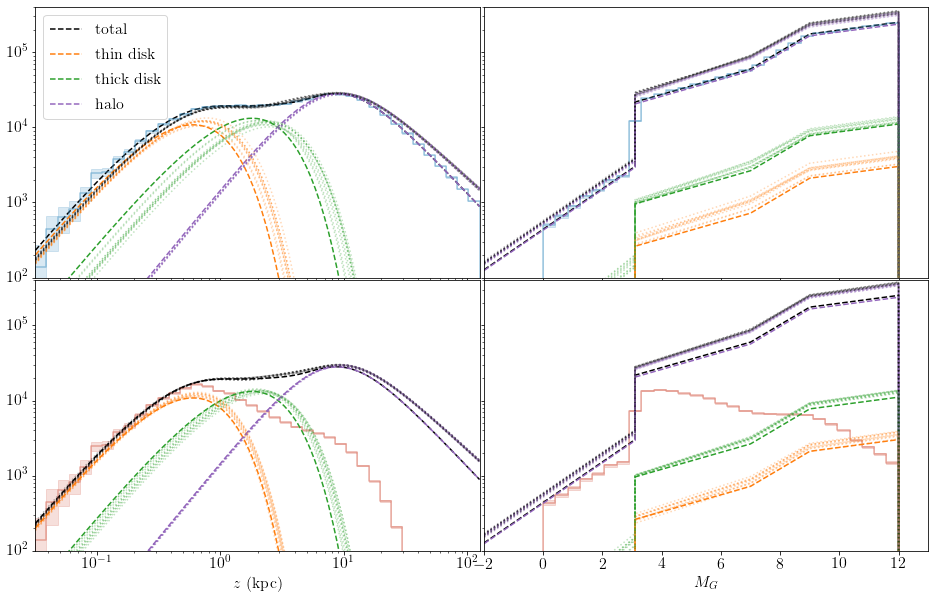

In [26]:
fig, axes = plt.subplots(2,2,figsize=(16,10), sharey=True, sharex='col')

true_parameters = true_params_f.copy()

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--', 'label':'total'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})

for jj, model in enumerate([model_z0, model_dust]):

    nwalker, nstep, ndim = model.mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model.mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    if jj==0:
        plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist((model.sample['s']*model.sample['sinb'])[model.sample['sf_subset']], 
                       np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.z_model(z_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 

    for mcmc_sample in mcmc_samples:
        axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    if jj==0: plt.legend()

    plt.sca(axes[jj,1])
    fixed_mags = np.array([true_pars['Mx'], true_pars['Mms'], 
                           true_pars['Mms1'], true_pars['Mms2'],
                           true_pars[0]['Mto'], true_pars[1]['Mto'], true_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))
    axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    
    if jj==0: 
        plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist(sample['M'][sample['sf_subset']], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.M_model(M_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **true_kwargs[i+1])

    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 


plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
        
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(100.,400000)#100000000)

# plt.savefig(f'figs/mock_sys_{file}_{size}_{run_id:03d}_zM_disthist.png', bbox_inches='tight', dpi=200)

In [27]:
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

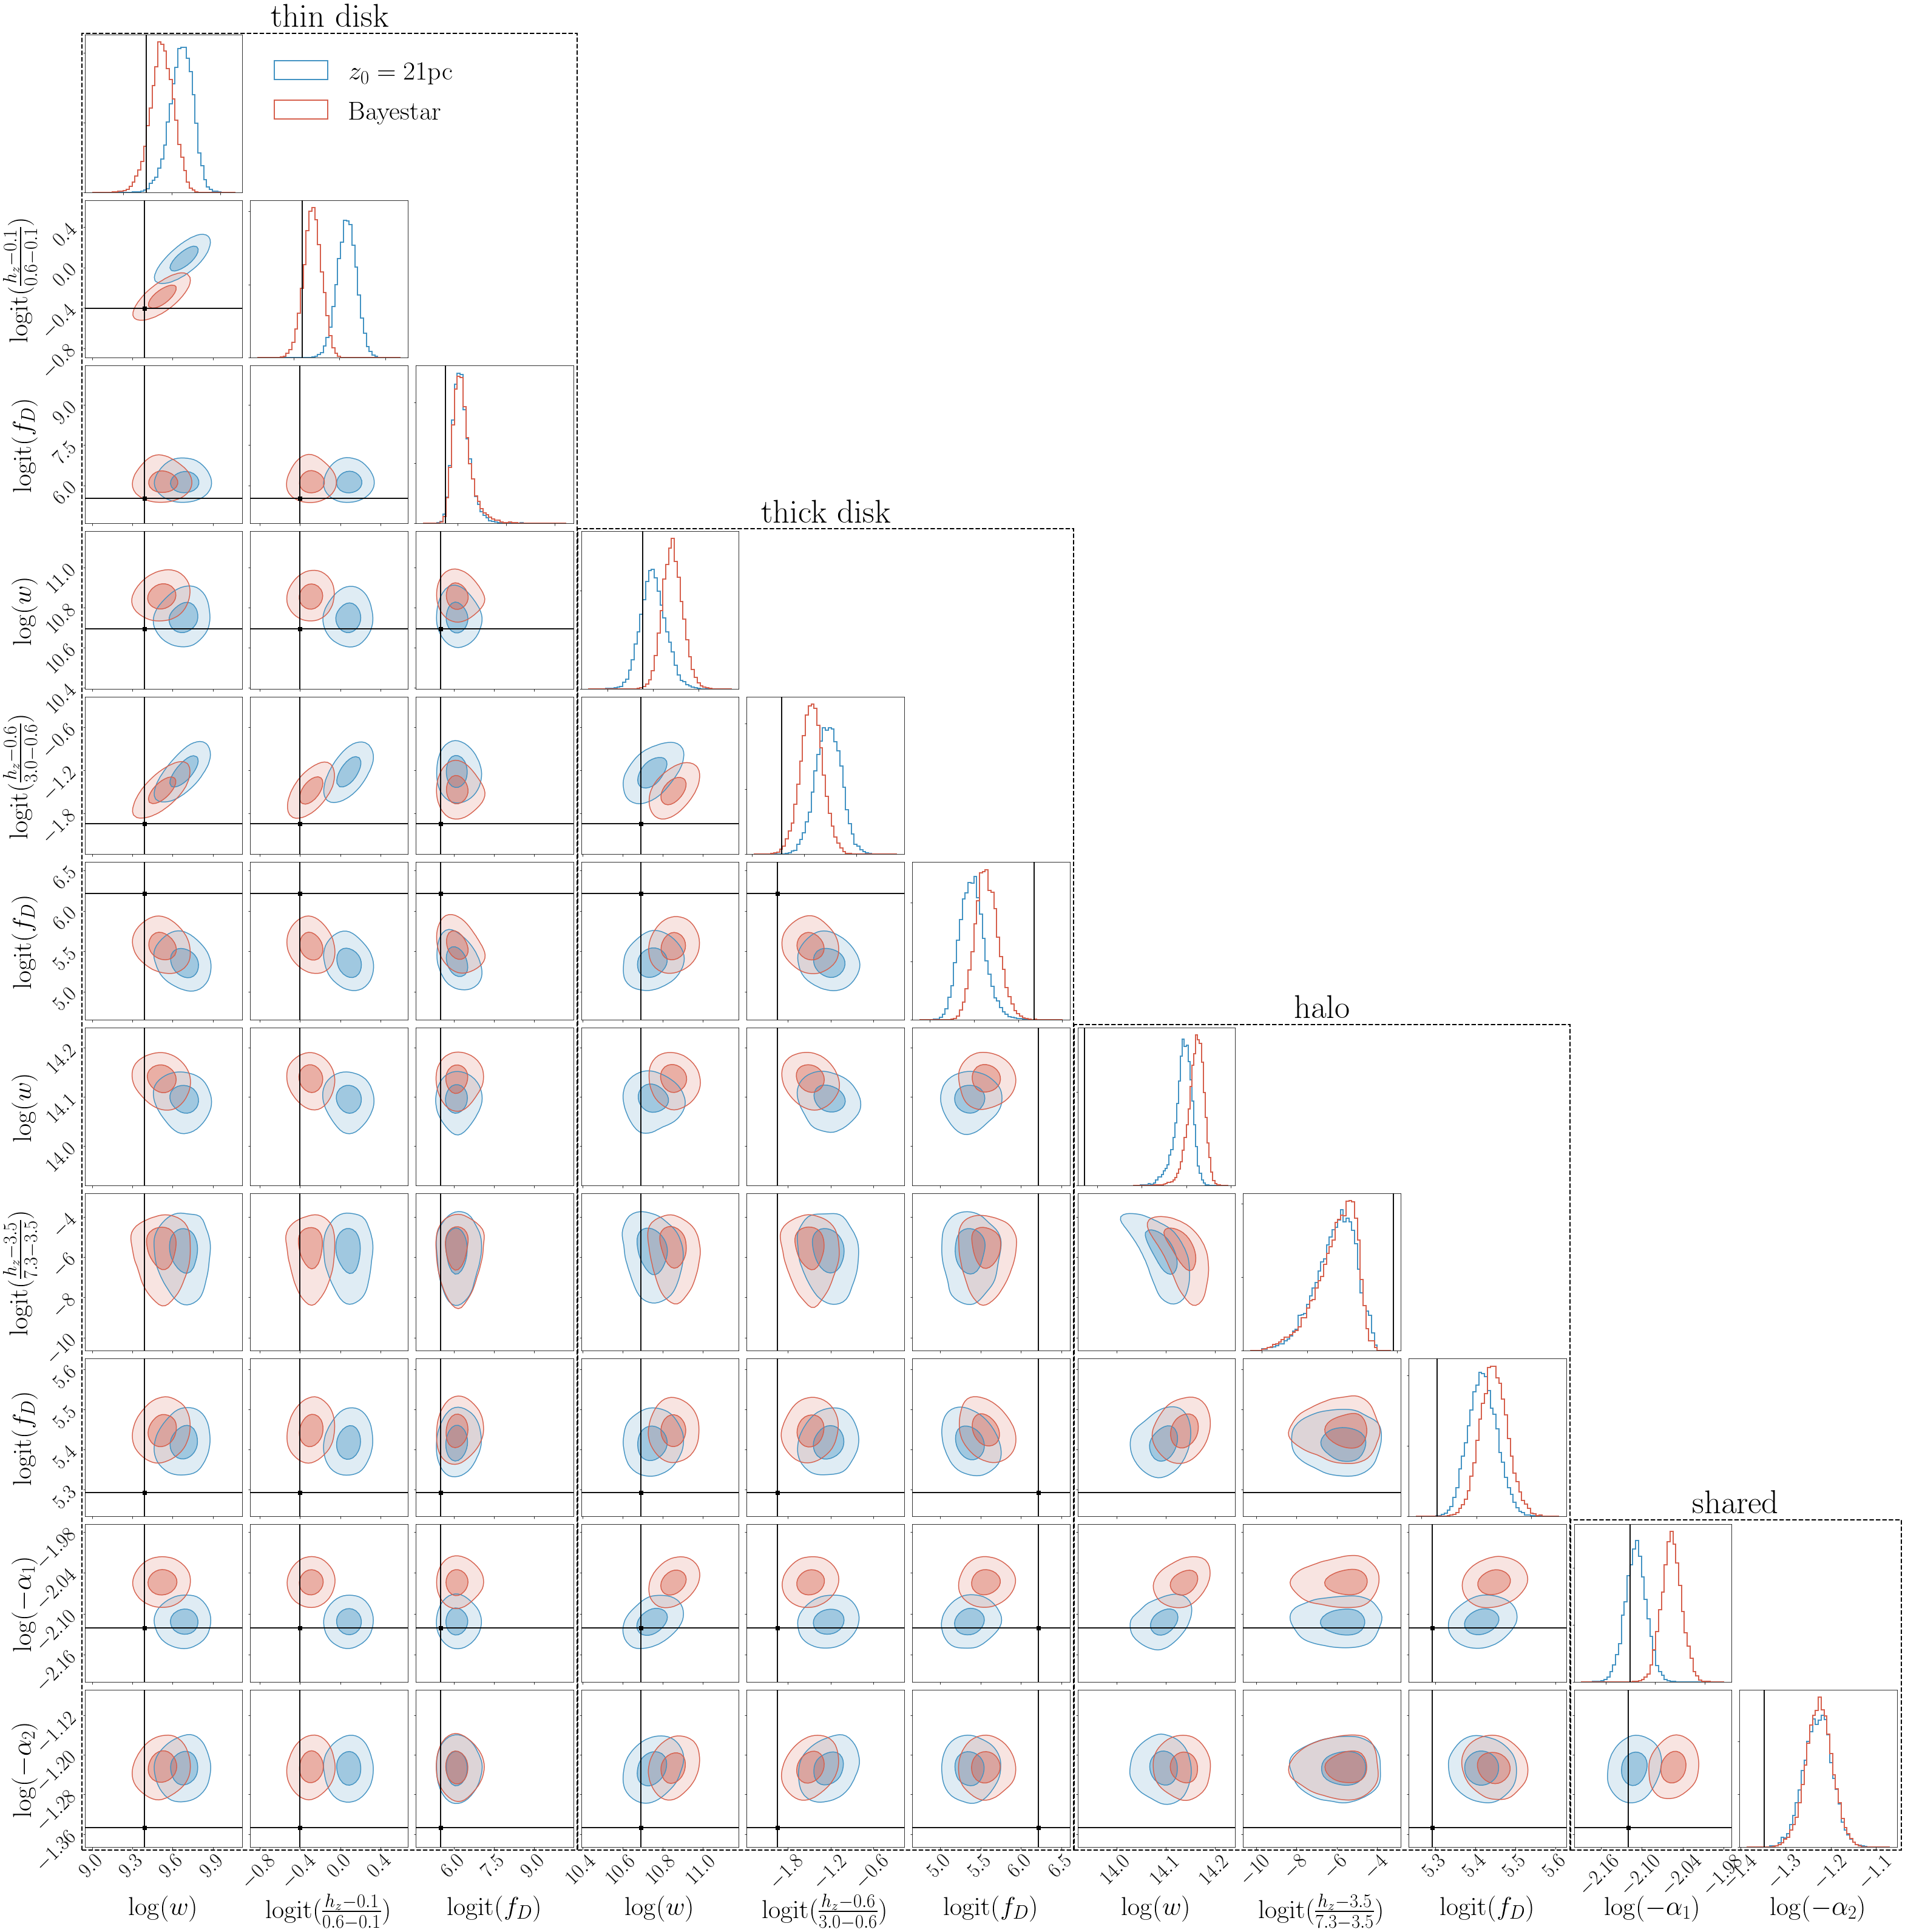

In [30]:
index = [r'$z_0=21$pc', r'Bayestar']
ndim=len(true_params_f); fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model_z0.mcmc_results['chain']['sf_perr_mcmc'],
                          model_dust.mcmc_results['chain']['sf_perr_mcmc']], 
                         index=index, truths=true_params_f, truth_color='k',
                         hist_kwargs={'linewidth':2}, 
                         labels=model.get_labels(),
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model_dust.free_pars[i]) for i in range(3)]+[len(model_dust.free_pars['shd'])]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
# plt.savefig(f'figs/mock_sys_{file}_{size}_{run_id:03d}_corner_f.png', bbox_inches='tight', dpi=200)

# Magnitude error

In [154]:
def apply_gerr(l_sample, b_sample, G_sample, n_field, _nside=64):

    c=SkyCoord(l=l_sample, b=b_sample, unit='rad', frame='galactic')
    _eq=c.icrs; _ra=_eq.ra.deg; _dec=_eq.dec.deg
    hpix = hp.ang2pix(_nside, _ra, _dec, lonlat=True, nest=True)

    # Collapse _n down to _nside
    n_field = np.median(n_field.reshape(hp.nside2npix(_nside), n_field.shape[0]//hp.nside2npix(_nside)), axis=1).astype(int)
    n_transit = n_field[hpix]

    print('G amplitude...')
    # Model for G error
    with h5py.File('/home/andy/Documents/Projects/GitRepos/selectionfunctions/selectionfunctions/examples/FIRE/median_gamp_edr3.h', 'r') as hf:
        gamp_interp = scipy.interpolate.interp1d(hf['magbin'][...]+0.05, hf['med_gamp'][...], 
                                    fill_value=(hf['med_gamp'][0],hf['med_gamp'][-1]), bounds_error=False)
    phot_g_error_amp = gamp_interp(G_sample)

    print('Number of observations...')
    # G-observations efficiency
    with h5py.File('/home/andy/Documents/Projects/GitRepos/selectionfunctions/selectionfunctions/examples/FIRE/expected_gobs_efficiency_edr3.h', 'r') as hf:
        eff_interp = scipy.interpolate.interp1d(hf['magbin'][...]+0.05, hf['mean_eff'][...], 
                                    fill_value=(0,0), bounds_error=False)
    # There are 9 CCD observations per transit in Gaia.
    # The efficiency is the expected number of CCD observations which results in a G-band measurement.
    phot_g_n_obs = n_transit * (62./7.) * eff_interp(G_sample)

    print('Draw G magnitude...')
    ### Expected G uncertainty
    IG_sample = 10**(-G_sample/2.5)
    IG_error = phot_g_error_amp * IG_sample / np.sqrt(phot_g_n_obs)
    IG_obs = np.random.normal(IG_sample, IG_error)
    G_obs = -2.5*np.log10(IG_obs)

    return G_obs

In [155]:
# Apply Gaia Selection Function
from selectionfunctions.carpentry import chisel
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

In [156]:
#CoGii.fetch()
dr3_sf = CoGii.dr3_sf(version='modelAB',crowding=False)

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.204 s
  auxilliary:   4.201 s
          sf:   0.002 s
interpolator:   0.001 s
Loading auxilliary data ...


In [157]:
_nside=64
from astropy.coordinates import SkyCoord
import astropy.units as units

In [158]:
N = 1000

l = np.random.rand(N)*360
sinb = np.random.rand(N)*(1-np.sin(3*np.pi/8)) + np.sin(3*np.pi/8)
b = np.arcsin(sinb)

G = np.random.rand(N)*1 + 20

In [159]:
Gobs = apply_gerr(l*np.pi/180, b*np.pi/180, G, dr3_sf._n_field, _nside=64)

G amplitude...
Number of observations...
Draw G magnitude...


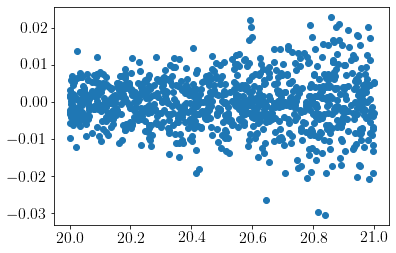

In [160]:
plt.scatter(G, G-Gobs)

In [161]:
np.std(G-Gobs)

0.006916501599870669

In [72]:
c=SkyCoord(l=l*np.pi/180, b=b*np.pi/180, unit='rad', frame='galactic')
_eq=c.icrs; _ra=_eq.ra.deg; _dec=_eq.dec.deg
hpix = hp.ang2pix(_nside, _ra, _dec, lonlat=True, nest=True)
# Collapse _n down to _nside
n_field = dr3_sf._n_field.copy()
n_field = np.median(n_field.reshape(hp.nside2npix(_nside), n_field.shape[0]//hp.nside2npix(_nside)), axis=1).astype(int)
n_transit = n_field[hpix]

In [73]:
n_transit

array([ 90,  30,  26,  26,  68,  69,  61,  48,  31,  43,  26,  38,  46,
        44,  51,  27,  52,  58,  50,  45,  32,  90,  46,  96,  49,  26,
        27,  26,  61,  48,  49,  50,  59,  46,  52,  26,  26,  49,  56,
        48,  52,  51,  27,  32,  55,  29,  68,  27,  50,  62,  67,  57,
        50,  47,  81,  62,  44,  27,  46,  31,  26,  26,  56,  46,  44,
        45,  26,  49,  27,  55,  58,  90,  45,  50,  47,  35,  27,  52,
        30,  44,  45,  26,  96,  69,  48,  27,  56,  32,  28,  27,  60,
        54,  26,  26,  59,  50,  52,  51,  26,  27,  69,  48,  47,  51,
       108,  50,  47,  50,  62,  64,  66,  55,  31,  63,  45,  31,  52,
        49,  49,  59,  29,  55,  26,  47,  51,  54,  29,  55,  47,  70,
        46,  26,  26,  57,  29,  47,  74,  61,  26,  26,  96,  49,  31,
        68,  80,  76,  44,  49,  29,  40,  81,  61,  72,  57,  45,  90,
        42,  29,  72,  39,  33,  45,  51,  26,  54,  46,  49,  27,  45,
        43, 100,  28,  49,  68,  48,  88,  47,  51,  54,  46,  2

In [153]:
print('G amplitude...')
# Model for G error
with h5py.File('/home/andy/Documents/Projects/GitRepos/selectionfunctions/selectionfunctions/examples/FIRE/median_gamp_edr3.h', 'r') as hf:
    gamp_interp = scipy.interpolate.interp1d(hf['magbin'][...]+0.05, hf['med_gamp'][...], fill_value=(hf['med_gamp'][0],hf['med_gamp'][-1]), bounds_error=False)
    print(np.min(hf['magbin'][...]))
phot_g_error_amp = gamp_interp(G)

G amplitude...
1.7000000000000002


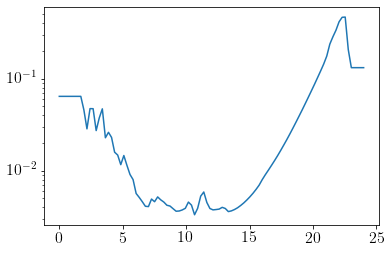

In [150]:
gtest = np.linspace(0,24,100)
plt.plot(gtest, gamp_interp(gtest))
plt.yscale('log')

In [147]:
print('Number of observations...')
# G-observations efficiency
with h5py.File('/home/andy/Documents/Projects/GitRepos/selectionfunctions/selectionfunctions/examples/FIRE/expected_gobs_efficiency_edr3.h', 'r') as hf:
    eff_interp = scipy.interpolate.interp1d(hf['magbin'][...]+0.05, hf['mean_eff'][...], fill_value=(0,0), bounds_error=False)
# There are 9 CCD observations per transit in Gaia.
# The efficiency is the expected number of CCD observations which results in a G-band measurement.
phot_g_n_obs = n_transit * (62./7.) * eff_interp(G)

Number of observations...


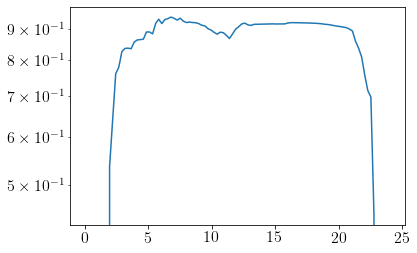

In [148]:
gtest = np.linspace(0,24,100)
plt.plot(gtest, eff_interp(gtest))
plt.yscale('log')

In [136]:
gamp_interp(gtest)

array([0.00407723, 0.00452618, 0.00457187, 0.00423108, 0.00354962,
       0.00334348, 0.00362828, 0.00430959, 0.00516974, 0.00588361,
       0.00580614, 0.00496602, 0.00429261, 0.00393759, 0.0038118 ,
       0.00375769, 0.00377108, 0.00380025, 0.0038187 , 0.00386436,
       0.00398295, 0.00417407, 0.00383034, 0.00359786, 0.00361227,
       0.00364973, 0.00371467, 0.0037919 , 0.00389689, 0.00400087,
       0.00413477, 0.00427774, 0.00444437, 0.00463127, 0.00483919,
       0.00506443, 0.00532301, 0.00560148, 0.00592197, 0.00626941,
       0.00665869, 0.0071132 , 0.00769216, 0.00837858, 0.00895658,
       0.00956797, 0.01023739, 0.01096169, 0.01175109, 0.01260263,
       0.01353695, 0.01456482, 0.01570352, 0.01697929, 0.01836195,
       0.01987222, 0.02153649, 0.0233689 , 0.02542797, 0.02767917,
       0.03018621, 0.03293972, 0.03597037, 0.03931697, 0.04294831,
       0.0470447 , 0.05154632, 0.05655461, 0.06209103, 0.06817794,
       0.07488562, 0.08220964, 0.09053559, 0.09986273, 0.11008

In [78]:
phot_g_error_amp / np.sqrt(phot_g_n_obs)

array([0.00141945, 0.00420375, 0.00069309, 0.00926216, 0.00015989,
       0.00053014, 0.00016186, 0.00018249, 0.02705916, 0.02387236,
       0.00177079, 0.00938997, 0.00286696, 0.00048475, 0.00018276,
       0.00150425, 0.0001971 , 0.00556636, 0.00018427, 0.0054667 ,
       0.00029853, 0.00031886, 0.00100957, 0.0013086 , 0.00712508,
       0.00062717, 0.00032057, 0.00044927, 0.00023937, 0.00720587,
       0.0007171 , 0.00062777, 0.00274832, 0.00018718, 0.00796401,
       0.00196548, 0.00097515, 0.00886075, 0.00019585, 0.00018244,
       0.0014841 , 0.01477466, 0.00038364, 0.01170011, 0.00056722,
       0.00030661, 0.00421366, 0.00077395, 0.00218423, 0.00175427,
       0.00116465, 0.00278539, 0.00075379, 0.00018984, 0.0005119 ,
       0.00150581, 0.00466566, 0.00052372, 0.00097949, 0.03312721,
       0.00027464, 0.00401644, 0.01252276, 0.00044115, 0.00096217,
       0.00020708, 0.00139402, 0.01749829, 0.00024364, 0.00017047,
       0.01552229, 0.00052023, 0.00030809, 0.00170007, 0.00050

In [137]:
scipy.interpolate.interp1d??

In [143]:
x = np.arange(5)
interp = scipy.interpolate.interp1d(x,x,fill_value=(10,-1), bounds_error=False)
interp(np.arange(-1,7))

array([10.,  0.,  1.,  2.,  3.,  4., -1., -1.])

In [92]:
IG = 10**((-G)/2.5)
IGobs = np.random.normal( IG, phot_g_error_amp * IG / np.sqrt(phot_g_n_obs) )
Gobs = -2.5*np.log10(IGobs)

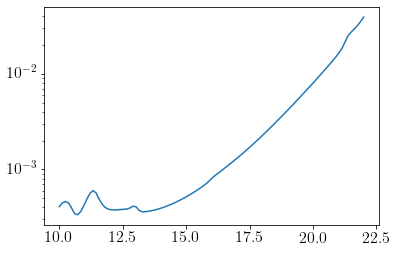

In [94]:
gtest = np.linspace(10,22,100)
plt.plot(gtest, gamp_interp(gtest)/10.)
plt.yscale('log')

In [93]:
(Gobs-G)

array([ 7.14652063e-04,  3.07398776e-03, -3.18057799e-04, -2.18777890e-02,
        2.52708551e-05,  6.50591169e-04, -1.60440686e-04,  5.11105712e-05,
       -3.10196533e-02, -1.69811837e-02,  1.61585140e-04,  8.28954190e-03,
       -1.15548075e-04, -2.05212578e-06, -9.99949159e-05, -1.62688856e-03,
        2.63100434e-04,  1.03477480e-02, -3.66296600e-04, -2.31065419e-04,
        5.36089288e-05, -7.02442527e-05,  3.85340093e-04, -3.15774828e-04,
       -3.75231200e-03, -4.88740661e-04, -5.22272339e-05,  2.26314580e-04,
        1.68249691e-04, -5.11062614e-04,  2.74523990e-04, -8.96775809e-04,
        3.53301232e-03,  3.18044660e-04, -7.16385235e-03,  1.44391696e-04,
       -6.22541738e-05,  5.35450240e-03, -1.19319232e-04, -9.06110400e-05,
       -2.78313862e-03,  3.45003587e-02,  3.70245352e-04, -5.60538448e-03,
       -7.93587582e-04, -3.08721329e-04, -3.23274819e-05,  2.24823211e-05,
        2.26319316e-03, -4.74523591e-04,  8.37224784e-04, -5.40729805e-03,
        1.52341481e-03,  

In [88]:
(IGobs - IG)/IG

array([ 6.75388189e-04,  1.11188659e-04,  1.07397191e-03, -6.58007205e-03,
       -7.66034018e-05,  7.35049005e-04,  1.09343637e-05,  1.37147949e-04,
        5.91028330e-02,  1.06233931e-03, -4.86014712e-03,  1.63789448e-03,
        2.05659456e-03,  1.28642447e-05, -1.08104543e-04, -5.52726038e-04,
       -5.03718722e-05, -1.70679902e-03,  2.07841960e-04,  3.10416802e-03,
        1.09899987e-04,  1.54713628e-04,  1.27752238e-04,  1.22386510e-03,
       -1.83814456e-02,  7.24510557e-04, -3.00129448e-04,  8.22361613e-04,
        3.55338788e-04,  9.42281884e-03, -6.09652171e-04, -7.13124300e-04,
        4.25921693e-03,  1.70744102e-04,  6.68513293e-03, -2.69587426e-03,
        1.67134808e-03,  2.28114999e-04, -1.27536094e-04, -3.14373631e-04,
        1.04078993e-03,  7.74854662e-03, -1.97394749e-04,  2.77005240e-02,
        2.67365039e-04, -1.65623026e-04, -5.27183021e-04,  6.72666651e-04,
        7.85844231e-04, -7.01467496e-05,  1.29234068e-04, -3.27296850e-04,
       -1.58632642e-04,  

In [85]:
np.random.normal(np.zeros(len(phot_g_error_amp)), phot_g_error_amp / np.sqrt(phot_g_n_obs))

array([ 3.27246585e-03,  3.46657552e-03,  3.56562771e-04,  3.13510467e-03,
        8.91362696e-05, -6.27860085e-04,  1.79662846e-05, -2.39798541e-05,
        1.59621041e-02, -1.27885078e-02, -7.17065211e-04,  3.73134253e-03,
        1.33698780e-04,  2.98583614e-04,  1.03056466e-06, -2.12774704e-03,
       -2.66851115e-04,  6.39990708e-03, -3.67406785e-05, -1.14920896e-02,
       -1.80576441e-05,  4.10331780e-04,  7.82440705e-04, -1.39254159e-04,
       -1.85926191e-03,  1.18312182e-04,  3.99270485e-05,  4.21997330e-04,
        3.25715793e-04,  5.85916040e-03,  1.71728407e-04, -2.64640068e-04,
       -1.06356425e-03,  1.15188298e-04,  2.15664616e-03, -3.36283029e-03,
        1.54229253e-03, -6.87575958e-03,  1.85624795e-04, -7.34353720e-05,
       -6.48126870e-04, -3.08662214e-03,  3.05602293e-04,  5.59359796e-03,
        2.98952894e-05,  1.49967245e-04, -4.76123156e-03,  1.33963377e-05,
        7.08429059e-04,  1.79508211e-03,  2.76932372e-03, -2.53432889e-03,
       -1.06648770e-03, -

In [86]:
np.random.normal?

In [82]:
IG - IGobs

array([-1.91245375e-11, -1.47377958e-12, -2.75899459e-10,  3.32638146e-11,
        2.39012609e-10, -1.24857967e-10, -5.25305674e-11, -6.78267849e-10,
       -9.37345219e-11, -9.68848578e-13,  2.49568227e-10, -6.51467519e-12,
       -3.44271045e-11, -3.97142456e-12,  5.91920519e-10,  3.55253399e-11,
        1.10058545e-10,  9.92421062e-12, -7.10105839e-10, -2.18745427e-11,
       -1.33309937e-10, -5.38668916e-11, -1.01591394e-11, -3.72368897e-11,
        8.69055332e-11, -2.26051496e-10,  3.79014034e-10, -4.68759629e-10,
       -3.26274087e-10, -4.44966051e-11,  8.17674691e-11,  1.19320174e-10,
       -6.36203172e-11, -7.42727723e-10, -2.68226169e-11,  1.18166682e-10,
       -2.27896115e-10, -8.43799674e-13,  2.46733131e-10,  1.45187419e-09,
       -4.13447854e-11, -1.80199296e-11,  1.54087397e-10, -9.61346010e-11,
       -4.94433384e-11,  2.14804574e-10,  3.98950739e-12, -1.35209454e-10,
       -1.82304012e-11,  1.91461097e-12, -6.10954205e-12,  4.91426666e-12,
        1.91658761e-11, -

In [66]:








print('Draw G magnitude...')
### Expected G uncertainty
IG_sample = 10**((-G_sample + 25.687)/2.5)
IG_error = phot_g_error_amp * IG_sample / np.sqrt(phot_g_n_obs)
IG_obs = np.random.normal(IG_sample, IG_error)
G_obs = -2.5*np.log10(IG_obs) - + 25.687

Draw G magnitude...


NameError: name 'G_sample' is not defined

In [54]:
sys.path.append('/home/andy/Documents/software/')
import sqlutilpy, getdata

In [95]:
query = """select phot_g_mean_mag, phot_g_mean_flux, phot_g_mean_flux_error, phot_g_n_obs
                from gaia_edr3.gaia_source
                where phot_g_mean_mag is not Null
                and phot_g_mean_mag between 19.9 and 20
                limit 10000"""
sample = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

In [96]:
sample['phot_g_mean_mag']

array([19.97837 , 19.950998, 19.990257, ..., 19.965752, 19.978727,
       19.988829], dtype=float32)

In [97]:
sample['phot_g_mean_flux']/sample['phot_g_mean_flux_error']

array([253.56294198, 272.75645627, 132.12745936, ..., 238.51785811,
       239.17311538, 221.40783767])

In [98]:
sample['phot_g_mean_flux']

array([192.13144883, 197.03689303, 190.03950937, ..., 194.37752425,
       192.06833655, 190.28972766])

In [99]:
F = sample['phot_g_mean_flux'][0]
err = F*np.mean(sample['phot_g_mean_flux_error']/sample['phot_g_mean_flux'])

In [103]:
Fsample = np.random.normal(F, err, 1000)

In [105]:
np.std(-2.5 * np.log10(Fsample) + 25.678)

0.005887165378627912

In [108]:
np.std(-2.5 * np.log10(Fsample))

0.005887165378627914

In [115]:
np.mean(sample['phot_g_n_obs'])

294.4091

In [117]:
np.nanmean(phot_g_n_obs)

377.37893822995386

In [62]:
10**(-sample['phot_g_mean_mag']/2.5)

array([3.6440273e-09, 7.8041804e-09, 7.1660358e-09, ..., 2.4553955e-08,
       6.2125531e-09, 8.5708036e-09], dtype=float32)

In [64]:
sample['phot_g_mean_mag'] - -2.5*np.log10(sample['phot_g_mean_flux'])

array([25.68736717, 25.68736658, 25.68736748, ..., 25.68736741,
       25.68736758, 25.68736626])

In [65]:
10**(-25.687/2.5)

5.3112898185501214e-11

# Dust map

In [6]:
from dustmaps.config import config
config['data_dir'] = '/data/asfe2/Projects/dustmaps/'

In [7]:
import dustmaps.bayestar
dustmaps.bayestar.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [13]:
from dustmaps.bayestar import BayestarQuery
from astropy.coordinates import SkyCoord
import astropy.units as units

In [9]:
bayestar = BayestarQuery(max_samples=1)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 20.968 s
  pix_info:   0.645 s
   samples:   5.981 s
      best:   5.959 s
       nan:   0.031 s
      sort:   8.171 s
       idx:   0.182 s


In [21]:
# Get healpix coordinates
hp_ra, hp_dec = hp.pix2ang(32, np.arange(hp.nside2npix(32)), nest=True, lonlat=True)
hp_eq=SkyCoord(ra=hp_ra*units.deg, dec=hp_dec*units.deg, distance=0.5*units.kpc)

In [27]:
ebv = bayestar(hp_eq, mode='random_sample') * 3.518

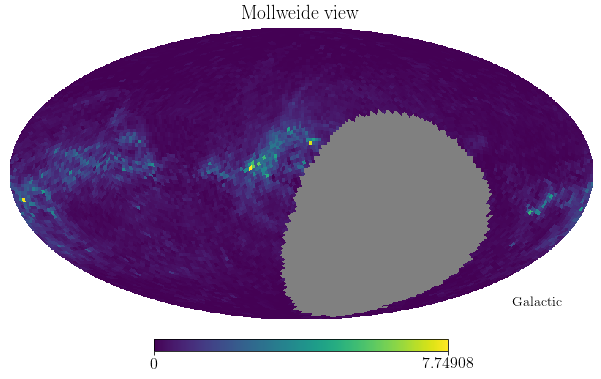

In [28]:
hp.mollview(ebv, nest=True, coord=['C','G'])

In [19]:
bayestar.distances.shape

(120,)

In [ ]:
def extinct(l, sinb, s, G):

    from dustmaps.bayestar import BayestarQuery

    b = np.rad2deg(np.arcsin(sinb))

    # Green, Schlafly, Finkbeiner et al. (2019)
    bayestar = BayestarQuery(max_samples=1)

    # Get healpix coordinates
    c = SkyCoord(l=l*units.deg, b=b*units.deg, distance=s*units.kpc, frame='galactic')
    
    # Apply dustmap
    Gext = G + bayestar(c, mode='random_sample') * 3.518
    
    return Gext